# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import hashlib
from base64 import b64encode
import os


c:\Users\leftg\Desktop\AB\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)

In [3]:
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

In [4]:
def salt_generator(salt=None):
    if salt is None:
        salt = os.urandom(8)
    return b64encode(salt).decode('ascii')

def groups_splitter(df, user_salt=None):
    if user_salt is None:
        salt = salt_generator()
    else:
        salt = user_salt
    df = df.copy()
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(
        lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()
    )
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2)
                   .map(lambda x: 'A' if x == 0 else 'B'))
    return df[['user_id', 'group']].drop_duplicates()


## Задание 1: Ранговая трансформация + t-test vs Манна-Уитни


Rank transformation:   0%|          | 0/100 [00:00<?, ?it/s]

Rank transformation: 100%|██████████| 100/100 [04:51<00:00,  2.91s/it]


Исходная метрика: p-value = 0.4678, mannwhitney p-value = 0.4772
T-test на рангах: p-value = 0.4772
KS test p-value: T-test исходный=0.211682, T-test ранг=0.392151, Манна-Уитни=0.392141
Манна-Уитни и t-test на рангах дают одинаковый результат


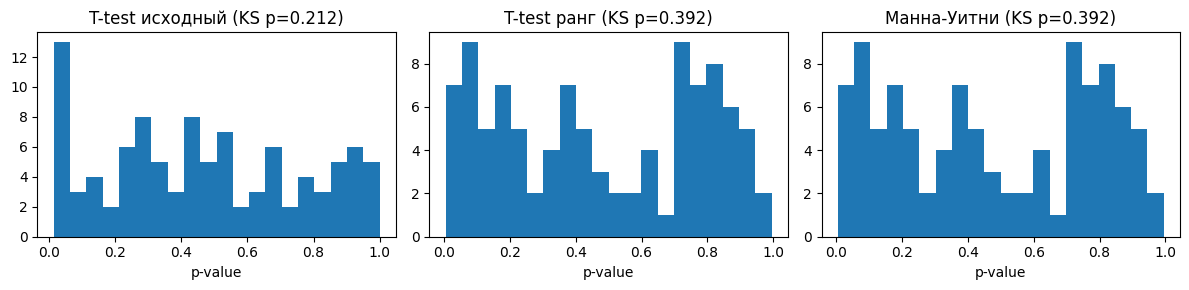

In [ ]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis=0)
    df['rank'] = df[metric].rank(method='average')
    return df

pvalues_orig = []
pvalues_rank = []
pvalues_mannwhitney = []
shop_base = shop_metrics_new[['user_id', 'cart_added_cnt']].copy()
for i in tqdm(range(100), desc="Rank transformation"):
    new_group = groups_splitter(shop_base.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop_base, new_group, on='user_id', how='left')
    df_a_new = new_df[new_df['group'] == 'A']
    df_b_new = new_df[new_df['group'] == 'B']
    metric_a_new = df_a_new['cart_added_cnt']
    metric_b_new = df_b_new['cart_added_cnt']
    t_orig = stats.ttest_ind(metric_a_new, metric_b_new)
    pvalues_orig.append(t_orig.pvalue)
    ranked_new = rank_transformation(df_a_new, df_b_new, 'cart_added_cnt')
    rank_a_new = ranked_new[ranked_new['group'] == 'A']['rank']
    rank_b_new = ranked_new[ranked_new['group'] == 'B']['rank']
    t_rank = stats.ttest_ind(rank_a_new, rank_b_new)
    pvalues_rank.append(t_rank.pvalue)
    mw = stats.mannwhitneyu(metric_a_new, metric_b_new, alternative='two-sided')
    pvalues_mannwhitney.append(mw.pvalue)

orig_t_test = np.mean(pvalues_orig)
mannwhitney_p_value = np.mean(pvalues_mannwhitney)
rank_t_test = np.mean(pvalues_rank)

print(f"Исходная метрика: p-value = {orig_t_test:.4f}, mannwhitney p-value = {mannwhitney_p_value:.4f}")
print(f"T-test на рангах: p-value = {rank_t_test:.4f}")

if np.round(mannwhitney_p_value, 5) == np.round(rank_t_test, 5):
    print("Манна-Уитни и t-test на рангах дают одинаковый результат")
else:
    print("Манна-Уитни и t-test на рангах дают разный результат")

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(pvalues_orig, bins=20)
plt.title('T-test исходный')
plt.xlabel('p-value')

plt.subplot(1, 3, 2)
plt.hist(pvalues_rank, bins=20)
plt.title('T-test ранг')
plt.xlabel('p-value')

plt.subplot(1, 3, 3)
plt.hist(pvalues_mannwhitney, bins=20)
plt.title('Манна-Уитни')
plt.xlabel('p-value')

plt.tight_layout()
plt.show()


## Задание 2: CUPED-трансформация


In [6]:
def cuped_transform(df, metrics, covariates=None):
    df = df.copy()
    
    if covariates is None:
        covariates = {m: str(m)+'_covariate' for m in metrics}
    
    new_columns = [str(m)+'_cuped' for m in metrics]
    for col in new_columns:
        df[col] = 0.0

    df_mini = df.fillna(0)
    theta_dict = {}
    
    for m in metrics:
        if m not in covariates:
            covariate_column = str(m)+'_covariate'
        else:
            covariate_column = covariates[m]
        cuped_column = str(m)+'_cuped'
        
        if covariate_column not in df_mini.columns:
            raise KeyError(f"Колонка '{covariate_column}' не найдена в датафрейме.")
        
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        theta_dict[m] = theta
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates(), theta_dict

shop_metrics_old_renamed = shop_metrics_old[['user_id', 'cart_added_cnt']].rename(
    columns={'cart_added_cnt': 'cart_added_cnt_covariate'}
)
shop_metrics_merged = pd.merge(
    shop_metrics_new[['user_id', 'group', 'cart_added_cnt']],
    shop_metrics_old_renamed,
    on='user_id',
    how='left'
)
shop_metrics_merged['cart_added_cnt_covariate'] = shop_metrics_merged['cart_added_cnt_covariate'].fillna(0)

cov_a = shop_metrics_merged[shop_metrics_merged['group'] == 'A']['cart_added_cnt_covariate']
cov_b = shop_metrics_merged[shop_metrics_merged['group'] == 'B']['cart_added_cnt_covariate']
t_test_cov = stats.ttest_ind(cov_a, cov_b).pvalue


print(f"Ковариата: A = {cov_a.mean():.4f}, B = {cov_b.mean():.4f}, p-value = {t_test_cov:.4f}")
if t_test_cov > 0.05:
    print("Ковариата сбалансирована")
else:
    print("Ковариата не сбалансирована")


Ковариата: A = 0.1406, B = 0.1434, p-value = 0.3065
Ковариата сбалансирована


In [7]:
def analyze_cuped_results(df_original, df_cuped, metric_name, cuped_suffix='_cuped', theta=None):
    """Анализирует результаты CUPED трансформации"""
    metric_a_orig = df_original[df_original['group'] == 'A'][metric_name]
    metric_b_orig = df_original[df_original['group'] == 'B'][metric_name]
    metric_a_cuped = df_cuped[df_cuped['group'] == 'A'][metric_name + cuped_suffix]
    metric_b_cuped = df_cuped[df_cuped['group'] == 'B'][metric_name + cuped_suffix]
    
    var_reduction_a = (1 - metric_a_cuped.var() / metric_a_orig.var()) * 100
    var_reduction_b = (1 - metric_b_cuped.var() / metric_b_orig.var()) * 100
    mean_diff_a = abs(metric_a_orig.mean() - metric_a_cuped.mean())
    mean_diff_b = abs(metric_b_orig.mean() - metric_b_cuped.mean())
    
    t_test_orig = stats.ttest_ind(metric_a_orig, metric_b_orig)
    t_test_cuped = stats.ttest_ind(metric_a_cuped, metric_b_cuped)
    
    print(f"Средние: до CUPED A = {metric_a_orig.mean():.4f}, B = {metric_b_orig.mean():.4f}")
    print(f"Средние: после CUPED A = {metric_a_cuped.mean():.4f}, B = {metric_b_cuped.mean():.4f}")
    print(f"Разница средних: A = {mean_diff_a:.4f}, B = {mean_diff_b:.4f}")
    
    print(f"Дисперсии: до CUPED A = {metric_a_orig.var():.4f}, B = {metric_b_orig.var():.4f}")
    print(f"Дисперсии: после CUPED A = {metric_a_cuped.var():.4f}, B = {metric_b_cuped.var():.4f}")
    print(f"Сокращение дисперсии: A = {var_reduction_a:.2f}%, B = {var_reduction_b:.2f}%")
    
    print(f"T-test: до CUPED p-value = {t_test_orig.pvalue:.4f}, после CUPED p-value = {t_test_cuped.pvalue:.4f}")
    if theta is not None:
        print(f"Theta = {theta:.4f}")
    
    return t_test_orig, t_test_cuped


### 2.1. CUPED на обычной метрике cart_added_cnt


In [8]:
df_cuped_original, theta_dict_original = cuped_transform(shop_metrics_merged.copy(), ['cart_added_cnt'])
theta_original = theta_dict_original['cart_added_cnt']

t_test_orig_2a, t_test_cuped_2a = analyze_cuped_results(
    shop_metrics_merged, 
    df_cuped_original, 
    'cart_added_cnt', 
    theta=theta_original
)


Средние: до CUPED A = 0.1350, B = 0.1386
Средние: после CUPED A = 0.1364, B = 0.1372
Разница средних: A = 0.0013, B = 0.0013
Дисперсии: до CUPED A = 0.3806, B = 0.4247
Дисперсии: после CUPED A = 0.0182, B = 0.0215
Сокращение дисперсии: A = 95.21%, B = 94.94%
T-test: до CUPED p-value = 0.1920, после CUPED p-value = 0.1659
Theta = 0.9350


### 2.2. CUPED на логарифмированной метрике cart_added_cnt


In [9]:
df_log = shop_metrics_merged.copy()
df_log['cart_added_cnt_ln'] = np.log(df_log['cart_added_cnt'] + 1)
df_log['cart_added_cnt_covariate_ln'] = np.log(df_log['cart_added_cnt_covariate'] + 1)

df_cuped_log, theta_dict_log = cuped_transform(df_log.copy(), ['cart_added_cnt_ln'], {'cart_added_cnt_ln': 'cart_added_cnt_covariate_ln'})
theta_log = theta_dict_log['cart_added_cnt_ln']

t_test_orig_2b, t_test_cuped_2b = analyze_cuped_results(
    df_log, 
    df_cuped_log, 
    'cart_added_cnt_ln', 
    theta=theta_log
)


Средние: до CUPED A = 0.0797, B = 0.0813
Средние: после CUPED A = 0.0803, B = 0.0807
Разница средних: A = 0.0006, B = 0.0006
Дисперсии: до CUPED A = 0.0647, B = 0.0663
Дисперсии: после CUPED A = 0.0021, B = 0.0018
Сокращение дисперсии: A = 96.82%, B = 97.35%
T-test: до CUPED p-value = 0.1460, после CUPED p-value = 0.0404
Theta = 0.9665


### 2.3. CUPED на ранговой метрике cart_added_cnt


In [10]:
df_rank = shop_metrics_merged.copy()
df_a_rank = df_rank[df_rank['group'] == 'A'].copy()
df_b_rank = df_rank[df_rank['group'] == 'B'].copy()

ranked_full = rank_transformation(df_a_rank, df_b_rank, 'cart_added_cnt')
df_rank = ranked_full[['user_id', 'group', 'cart_added_cnt', 'rank', 'cart_added_cnt_covariate']].copy()
ranked_cov = rank_transformation(df_a_rank, df_b_rank, 'cart_added_cnt_covariate')
df_rank['rank_covariate'] = ranked_cov['rank']

df_cuped_rank, theta_dict_rank = cuped_transform(df_rank.copy(), ['rank'])
theta_rank = theta_dict_rank['rank']

t_test_orig_2c, t_test_cuped_2c = analyze_cuped_results(
    df_rank, 
    df_cuped_rank, 
    'rank', 
    theta=theta_rank
)


Средние: до CUPED A = 111170.4563, B = 111351.6422
Средние: после CUPED A = 111242.9144, B = 111279.1052
Разница средних: A = 72.4581, B = 72.5370
Дисперсии: до CUPED A = 1116108735.2908, B = 1132936846.7436
Дисперсии: после CUPED A = 27188807.8374, B = 23441920.6708
Сокращение дисперсии: A = 97.56%, B = 97.93%
T-test: до CUPED p-value = 0.2025, после CUPED p-value = 0.0898
Theta = 0.9798


### 2.4. Проверка мощности и корректности t-критерия для CUPED


Оригинал:   0%|          | 0/100 [00:00<?, ?it/s]

Ранг: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Оригинал: мощность = 100.0%, корректность = 92.0%
Логарифм: мощность = 100.0%, корректность = 97.0%
Ранг: мощность = 100.0%, корректность = 95.0%
KS test p-value: Оригинал=0.500973, Логарифм=0.132994, Ранг=0.397125


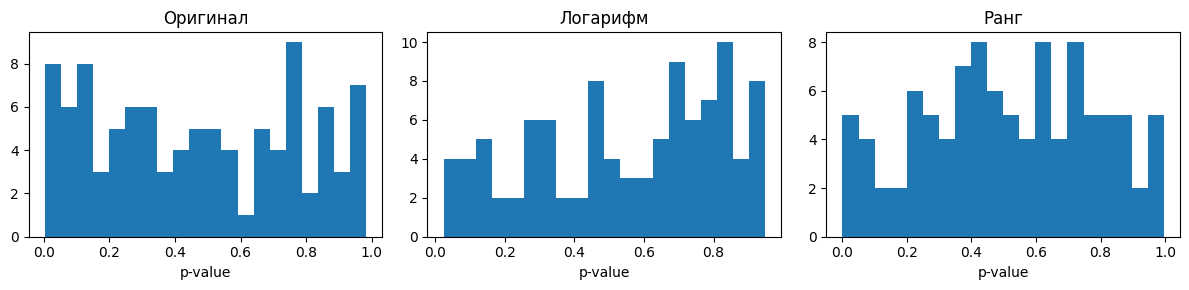

In [28]:
def check_power_correctness(df_base, metric_col, group_col='group', effect_size=1.05, n_iterations=100, desc=None):
    correctness = []
    power = []
    shop_base = df_base.drop(columns=[group_col] if group_col in df_base.columns else [])
    
    if desc is None:
        desc = f"Проверка {metric_col}"
    
    for i in tqdm(range(n_iterations), desc=desc):
        new_group = groups_splitter(shop_base.copy(), user_salt=salt_generator())
        new_df = pd.merge(
            df_base.drop(columns=[group_col] if group_col in df_base.columns else []),
            new_group, 
            how="left", 
            on=['user_id']
        ).drop_duplicates()
        
        vec_a = new_df[new_df['group'] == 'A'][metric_col]
        vec_b = new_df[new_df['group'] == 'B'][metric_col]
        vec_b_effect = vec_b * effect_size
        
        p_cor = stats.ttest_ind(vec_a, vec_b)[1]
        correctness.append(p_cor)
        p_power = stats.ttest_ind(vec_a, vec_b_effect)[1]
        power.append(p_power)
    
    correctness = np.array(correctness)
    power = np.array(power)
    power_rate = (power[power < 0.05].shape[0] / power.shape[0]) * 100
    correctness_rate = (1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100
    
    return {'power': power_rate, 'correctness': correctness_rate, 'correctness_pvalues': correctness}


results_power_2a = check_power_correctness(
    df_cuped_original[['user_id', 'group', 'cart_added_cnt_cuped']].rename(
        columns={'cart_added_cnt_cuped': 'metric'}
    ),
    'metric', 
    n_iterations=100,
    desc='Оригинал'
)

results_power_2b = check_power_correctness(
    df_cuped_log[['user_id', 'group', 'cart_added_cnt_ln_cuped']].rename(
        columns={'cart_added_cnt_ln_cuped': 'metric'}
    ),
    'metric', 
    n_iterations=100,
    desc='Логарифм'
)

results_power_2c = check_power_correctness(
    df_cuped_rank[['user_id', 'group', 'rank_cuped']].rename(
        columns={'rank_cuped': 'metric'}
    ),
    'metric', 
    n_iterations=100,
    desc='Ранг'
)

print(f"Оригинал: мощность = {results_power_2a['power']:.1f}%, корректность = {results_power_2a['correctness']:.1f}%")
print(f"Логарифм: мощность = {results_power_2b['power']:.1f}%, корректность = {results_power_2b['correctness']:.1f}%")
print(f"Ранг: мощность = {results_power_2c['power']:.1f}%, корректность = {results_power_2c['correctness']:.1f}%")

ks_2a = stats.kstest(results_power_2a['correctness_pvalues'], 'uniform')
ks_2b = stats.kstest(results_power_2b['correctness_pvalues'], 'uniform')
ks_2c = stats.kstest(results_power_2c['correctness_pvalues'], 'uniform')

print(f"KS test p-value: Оригинал={ks_2a.pvalue:.6f}, Логарифм={ks_2b.pvalue:.6f}, Ранг={ks_2c.pvalue:.6f}")

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(results_power_2a['correctness_pvalues'], bins=20)
plt.title('Оригинал')
plt.xlabel('p-value')

plt.subplot(1, 3, 2)
plt.hist(results_power_2b['correctness_pvalues'], bins=20)
plt.title('Логарифм')
plt.xlabel('p-value')

plt.subplot(1, 3, 3)
plt.hist(results_power_2c['correctness_pvalues'], bins=20)
plt.title('Ранг')
plt.xlabel('p-value')

plt.tight_layout()
plt.show()


## Задание 3: Бакетирование


In [16]:
def bucket_metric(df, metric_col, group_col='group', n_buckets=10, method='quantile'):
    df = df.copy()
    if method == 'quantile':
        df['bucket'] = pd.qcut(df[metric_col], q=n_buckets, duplicates='drop', labels=False)
    else:
        df['bucket'] = pd.cut(df[metric_col], bins=n_buckets, labels=False, duplicates='drop')
    
    bucketed = df.groupby([group_col, 'bucket'])[metric_col].agg(['mean', 'count']).reset_index()
    bucketed.columns = [group_col, 'bucket', 'metric_mean', 'count']
    return bucketed

def ttest_bucketed(bucketed_df, group_col='group'):
    group_a = bucketed_df[bucketed_df[group_col] == 'A']
    group_b = bucketed_df[bucketed_df[group_col] == 'B']
    metric_a = group_a['metric_mean']
    metric_b = group_b['metric_mean']
    return stats.ttest_ind(metric_a, metric_b)


### 3.1. Бакетирование на логнормальном распределении


Bucketing lognormal: 100%|██████████| 100/100 [00:02<00:00, 41.17it/s]


Без бакетирования: p-value = 0.5249, A = 12.1874, B = 12.1779
С бакетированием: p-value = 0.9790, A = 12.1798, B = 12.1860, бакетов = 20
KS test p-value: Без бакетирования=0.576345, С бакетированием=0.000000


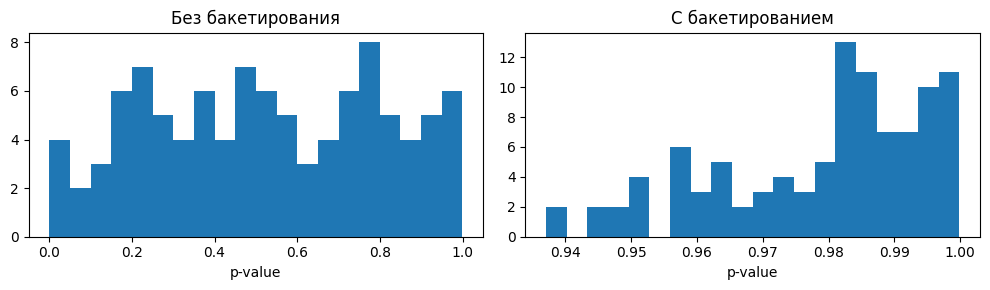

In [ ]:

n_samples = 10000
mu, sigma = 2.0, 1.0

pvalues_no_bucket = []
pvalues_bucket = []
means_a_no_bucket = []
means_b_no_bucket = []
means_a_bucket = []
means_b_bucket = []
for i in tqdm(range(100), desc="Bucketing lognormal"):
    data_a_new = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples // 2)
    data_b_new = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples // 2)
    t_no_bucket = stats.ttest_ind(data_a_new, data_b_new)
    pvalues_no_bucket.append(t_no_bucket.pvalue)
    means_a_no_bucket.append(data_a_new.mean())
    means_b_no_bucket.append(data_b_new.mean())
    df_new = pd.DataFrame({
        'user_id': range(n_samples),
        'group': ['A'] * (n_samples // 2) + ['B'] * (n_samples // 2),
        'metric': np.concatenate([data_a_new, data_b_new])
    })
    bucketed_new = bucket_metric(df_new, 'metric', n_buckets=20, method='quantile')
    t_bucket = ttest_bucketed(bucketed_new)
    pvalues_bucket.append(t_bucket.pvalue)
    means_a_bucket.append(bucketed_new[bucketed_new['group'] == 'A']['metric_mean'].mean())
    means_b_bucket.append(bucketed_new[bucketed_new['group'] == 'B']['metric_mean'].mean())

t_test_no_bucket = np.mean(pvalues_no_bucket)
t_test_bucket = np.mean(pvalues_bucket)
mean_a = np.mean(means_a_no_bucket)
mean_b = np.mean(means_b_no_bucket)
mean_a_b = np.mean(means_a_bucket)
mean_b_b = np.mean(means_b_bucket)

ks_no_bucket = stats.kstest(pvalues_no_bucket, 'uniform')
ks_bucket = stats.kstest(pvalues_bucket, 'uniform')

print(f"Без бакетирования: p-value = {t_test_no_bucket:.4f}, A = {mean_a:.4f}, B = {mean_b:.4f}")
print(f"С бакетированием: p-value = {t_test_bucket:.4f}, A = {mean_a_b:.4f}, B = {mean_b_b:.4f}, бакетов = 20")
print(f"KS test p-value: Без бакетирования={ks_no_bucket.pvalue:.6f}, С бакетированием={ks_bucket.pvalue:.6f}")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(pvalues_no_bucket, bins=20)
plt.title('Без бакетирования')
plt.xlabel('p-value')

plt.subplot(1, 2, 2)
plt.hist(pvalues_bucket, bins=20)
plt.title('С бакетированием')
plt.xlabel('p-value')

plt.tight_layout()
plt.show()

print(f"Без бакетирования: KS p-value={ks_no_bucket.pvalue:.4f} - {'Равномерное распределение (тест корректен)' if ks_no_bucket.pvalue > 0.05 else 'Неравномерное распределение (тест некорректен)'}")
print(f"С бакетированием: KS p-value={ks_bucket.pvalue:.4f} - {'Равномерное распределение (тест корректен)' if ks_bucket.pvalue > 0.05 else 'Неравномерное распределение (тест некорректен)'}")



### 3.2. Бакетирование на метрике cart_added_cnt


Bucketing cart_added_cnt:   0%|          | 0/100 [00:00<?, ?it/s]

Bucketing cart_added_cnt: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Без бакетирования: p-value = 0.4962, A = 0.1369, B = 0.1367, дисперсия A = 0.4060, B = 0.3993
С бакетированием: p-value = 0.9864, A = 1.5684, B = 1.5665, бакетов = 20
KS test p-value: Без бакетирования=0.779877, С бакетированием=0.000000


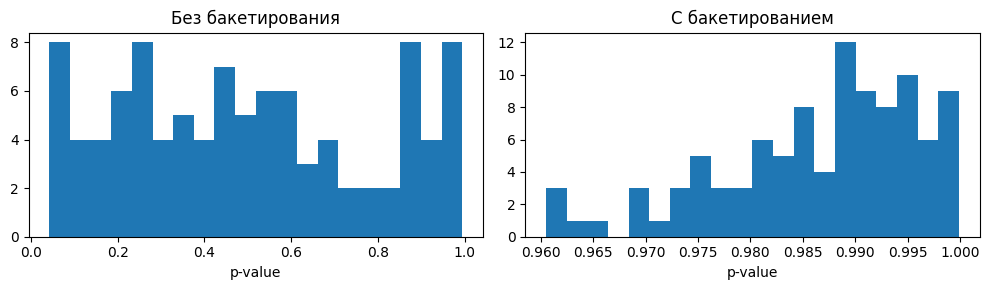

In [ ]:
pvalues_no_bucket_cart = []
pvalues_bucket_cart = []
means_a_no_bucket = []
means_b_no_bucket = []
vars_a_no_bucket = []
vars_b_no_bucket = []
means_a_bucket = []
means_b_bucket = []
shop_base_cart = shop_metrics_new[['user_id', 'cart_added_cnt']].copy()
for i in tqdm(range(100), desc="Bucketing cart_added_cnt"):
    new_group = groups_splitter(shop_base_cart.copy(), user_salt=salt_generator())
    new_df_cart = pd.merge(shop_base_cart, new_group, on='user_id', how='left')
    metric_a_new = new_df_cart[new_df_cart['group'] == 'A']['cart_added_cnt']
    metric_b_new = new_df_cart[new_df_cart['group'] == 'B']['cart_added_cnt']
    t_no_bucket = stats.ttest_ind(metric_a_new, metric_b_new)
    pvalues_no_bucket_cart.append(t_no_bucket.pvalue)
    means_a_no_bucket.append(metric_a_new.mean())
    means_b_no_bucket.append(metric_b_new.mean())
    vars_a_no_bucket.append(metric_a_new.var())
    vars_b_no_bucket.append(metric_b_new.var())
    bucketed_new = bucket_metric(new_df_cart, 'cart_added_cnt', n_buckets=20, method='quantile')
    t_bucket = ttest_bucketed(bucketed_new)
    pvalues_bucket_cart.append(t_bucket.pvalue)
    means_a_bucket.append(bucketed_new[bucketed_new['group'] == 'A']['metric_mean'].mean())
    means_b_bucket.append(bucketed_new[bucketed_new['group'] == 'B']['metric_mean'].mean())

t_test_no_bucket_cart = np.mean(pvalues_no_bucket_cart)
t_test_bucket_cart = np.mean(pvalues_bucket_cart)
mean_a_cart = np.mean(means_a_no_bucket)
mean_b_cart = np.mean(means_b_no_bucket)
var_a_cart = np.mean(vars_a_no_bucket)
var_b_cart = np.mean(vars_b_no_bucket)
mean_a_b_cart = np.mean(means_a_bucket)
mean_b_b_cart = np.mean(means_b_bucket)

ks_no_bucket_cart = stats.kstest(pvalues_no_bucket_cart, 'uniform')
ks_bucket_cart = stats.kstest(pvalues_bucket_cart, 'uniform')

print(f"Без бакетирования: p-value = {t_test_no_bucket_cart:.4f}, A = {mean_a_cart:.4f}, B = {mean_b_cart:.4f}, дисперсия A = {var_a_cart:.4f}, B = {var_b_cart:.4f}")
print(f"С бакетированием: p-value = {t_test_bucket_cart:.4f}, A = {mean_a_b_cart:.4f}, B = {mean_b_b_cart:.4f}, бакетов = 20")
print(f"KS test p-value: Без бакетирования={ks_no_bucket_cart.pvalue:.6f}, С бакетированием={ks_bucket_cart.pvalue:.6f}")

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(pvalues_no_bucket_cart, bins=20)
plt.title('Без бакетирования')
plt.xlabel('p-value')

plt.subplot(1, 2, 2)
plt.hist(pvalues_bucket_cart, bins=20)
plt.title('С бакетированием')
plt.xlabel('p-value')

plt.tight_layout()
plt.show()

print(f"Без бакетирования: KS p-value={ks_no_bucket_cart.pvalue:.4f} - {'Равномерное распределение (тест корректен)' if ks_no_bucket_cart.pvalue > 0.05 else 'Неравномерное распределение (тест некорректен)'}")
print(f"С бакетированием: KS p-value={ks_bucket_cart.pvalue:.4f} - {'Равномерное распределение (тест корректен)' if ks_bucket_cart.pvalue > 0.05 else 'Неравномерное распределение (тест некорректен)'}")

## Задание 4: Постстратификация


In [13]:
df_strat = pd.merge(
    shop_metrics_old[['user_id', 'cart_added_cnt']],
    shop_users_info[['user_id', 'user_age', 'user_sex']],
    on='user_id',
    how='left'
)

def create_age_group(age):
    if pd.isna(age):
        return 'unknown'
    elif age < 18:
        return 'under_18'
    elif 18 <= age <= 24:
        return '18-24'
    elif 25 <= age <= 45:
        return '25-45'
    elif 46 <= age <= 60:
        return '46-60'
    elif 61 <= age <= 75:
        return '61-75'
    else:
        return '76+'

df_strat['age_group'] = df_strat['user_age'].apply(create_age_group)
group_mapping = shop_metrics_new[['user_id', 'group']].set_index('user_id')['group'].to_dict()
df_strat['group'] = df_strat['user_id'].map(group_mapping)
df_strat = df_strat.dropna(subset=['group'])

df_strat['strat'] = df_strat['user_sex'].astype(str) + '_' + df_strat['age_group'].astype(str)

print("Распределение по стратам:")
print(df_strat['strat'].value_counts().head(10))


Распределение по стратам:
strat
m_25-45    42086
m_46-60    29693
m_61-75    29607
f_25-45    27881
f_46-60    19955
f_61-75    19882
m_76+      17849
m_18-24    14077
f_76+      12154
f_18-24     9337
Name: count, dtype: int64


### 4.1. Результаты без постстратификации


In [14]:
metric_a_no_strat = df_strat[df_strat['group'] == 'A']['cart_added_cnt']
metric_b_no_strat = df_strat[df_strat['group'] == 'B']['cart_added_cnt']
t_test_no_strat = stats.ttest_ind(metric_a_no_strat, metric_b_no_strat)

print(f"Без постстратификации: A среднее = {metric_a_no_strat.mean():.4f}, дисперсия = {metric_a_no_strat.var():.4f}, n = {len(metric_a_no_strat)}")
print(f"Без постстратификации: B среднее = {metric_b_no_strat.mean():.4f}, дисперсия = {metric_b_no_strat.var():.4f}, n = {len(metric_b_no_strat)}")
print(f"T-test: p-value = {t_test_no_strat.pvalue:.4f}, эффект = {((metric_b_no_strat.mean() - metric_a_no_strat.mean()) / metric_a_no_strat.mean() * 100):.2f}%")


Без постстратификации: A среднее = 0.1406, дисперсия = 0.4114, n = 111321
Без постстратификации: B среднее = 0.1434, дисперсия = 0.4643, n = 111200
T-test: p-value = 0.3065, эффект = 2.04%


### 4.2. Результаты с постстратификацией


In [ ]:
N_total = len(df_strat)
strata_weights = df_strat['strat'].value_counts() / N_total
strata_stats = df_strat.groupby(['group', 'strat'])['cart_added_cnt'].agg(['mean', 'var', 'count']).reset_index()
strata_stats.columns = ['group', 'strat', 'mean', 'var', 'count']

mean_a_strat = 0
mean_b_strat = 0
var_a_strat = 0
var_b_strat = 0

for strat in strata_weights.index:
    weight = strata_weights[strat]
    stats_a = strata_stats[(strata_stats['group'] == 'A') & (strata_stats['strat'] == strat)]
    if len(stats_a) > 0:
        mean_a_strat += stats_a.iloc[0]['mean'] * weight
        var_a_strat += stats_a.iloc[0]['var'] * weight
    
    stats_b = strata_stats[(strata_stats['group'] == 'B') & (strata_stats['strat'] == strat)]
    if len(stats_b) > 0:
        mean_b_strat += stats_b.iloc[0]['mean'] * weight
        var_b_strat += stats_b.iloc[0]['var'] * weight

n_a = len(metric_a_no_strat)
n_b = len(metric_b_no_strat)
std_a_strat = np.sqrt(var_a_strat)
std_b_strat = np.sqrt(var_b_strat)

t_test_strat = stats.ttest_ind_from_stats(
    mean_a_strat, std_a_strat, n_a,
    mean_b_strat, std_b_strat, n_b
)

var_reduction_a_strat = (1 - var_a_strat / metric_a_no_strat.var()) * 100
var_reduction_b_strat = (1 - var_b_strat / metric_b_no_strat.var()) * 100

print(f"С постстратификацией: A среднее = {mean_a_strat:.4f}, дисперсия = {var_a_strat:.4f}, сокращение = {var_reduction_a_strat:.2f}%")
print(f"С постстратификацией: B среднее = {mean_b_strat:.4f}, дисперсия = {var_b_strat:.4f}, сокращение = {var_reduction_b_strat:.2f}%")
print(f"T-test: p-value = {t_test_strat.pvalue:.4f}, эффект = {((mean_b_strat - mean_a_strat) / mean_a_strat * 100):.2f}%")
print(f"Сравнение средних: A {metric_a_no_strat.mean():.4f} -> {mean_a_strat:.4f}, B {metric_b_no_strat.mean():.4f} -> {mean_b_strat:.4f}")


С постстратификацией: A среднее = 0.1406, дисперсия = 0.4116, сокращение = -0.05%
С постстратификацией: B среднее = 0.1434, дисперсия = 0.4642, сокращение = 0.02%
T-test: p-value = 0.3089, эффект = 2.03%
Сравнение средних: A 0.1406 -> 0.1406, B 0.1434 -> 0.1434


### 4.3. Проверка мощности и корректности t-критерия для постстратификации


Постстратификация:   0%|          | 0/100 [00:00<?, ?it/s]

Постстратификация: 100%|██████████| 100/100 [02:22<00:00,  1.42s/it]

Мощность = 100.0%, корректность = 95.0%
KS test p-value: Постстратификация=0.420526


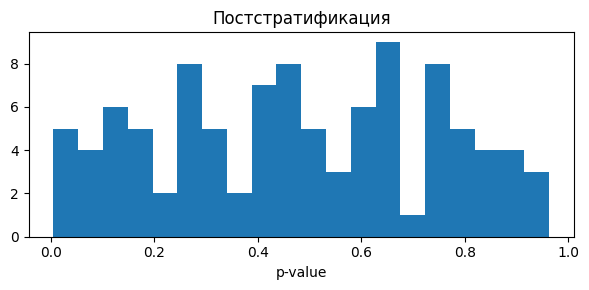

In [27]:
def stratified_ttest(df, metric_col='cart_added_cnt', group_col='group', strat_col='strat', effect_size=1.05):
    N_total = len(df)
    strata_weights = df[strat_col].value_counts() / N_total
    strata_stats = df.groupby([group_col, strat_col])[metric_col].agg(['mean', 'var', 'count']).reset_index()
    strata_stats.columns = [group_col, strat_col, 'mean', 'var', 'count']

    mean_a = 0
    mean_b = 0
    var_a = 0
    var_b = 0

    for strat in strata_weights.index:
        weight = strata_weights[strat]

        stats_a = strata_stats[(strata_stats[group_col] == 'A') & (strata_stats[strat_col] == strat)]
        stats_b = strata_stats[(strata_stats[group_col] == 'B') & (strata_stats[strat_col] == strat)]

        if len(stats_a) == 0 or len(stats_b) == 0:
            continue

        var_a_val = stats_a.iloc[0]['var']
        var_b_val = stats_b.iloc[0]['var']

        if np.isnan(var_a_val):
            var_a_val = 0
        if np.isnan(var_b_val):
            var_b_val = 0

        mean_a += stats_a.iloc[0]['mean'] * weight
        var_a += var_a_val * weight

        mean_b += stats_b.iloc[0]['mean'] * weight
        var_b += var_b_val * weight

    mean_b_effect = mean_b * effect_size
    n_a = len(df[df[group_col] == 'A'])
    n_b = len(df[df[group_col] == 'B'])
    std_a = np.sqrt(var_a)
    std_b = np.sqrt(var_b)

    t_test_aa = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)
    t_test_ab = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b_effect, std_b, n_b)

    return t_test_aa.pvalue, t_test_ab.pvalue


correctness_strat = []
power_strat = []
shop_base_strat = df_strat.drop(columns=['group'])

for i in tqdm(range(100), desc="Постстратификация"):
    new_group = groups_splitter(shop_base_strat.copy(), user_salt=salt_generator())
    new_df_strat = pd.merge(
        shop_base_strat,
        new_group,
        how="left",
        on=['user_id']
    ).drop_duplicates()
    
    if 'strat' not in new_df_strat.columns:
        new_df_strat['strat'] = new_df_strat['user_sex'].astype(str) + '_' + new_df_strat['age_group'].astype(str)

    mask_b = new_df_strat['group'] == 'B'
    new_df_strat_effect = new_df_strat.copy()
    new_df_strat_effect['cart_added_cnt'] = new_df_strat_effect['cart_added_cnt'].astype(float)
    new_df_strat_effect.loc[mask_b, 'cart_added_cnt'] *= 1.05

    p_cor, _ = stratified_ttest(new_df_strat, effect_size=1.0)
    correctness_strat.append(p_cor)

    _, p_power = stratified_ttest(new_df_strat_effect, effect_size=1.05)
    power_strat.append(p_power)

correctness_strat = np.array(correctness_strat)
power_strat = np.array(power_strat)

power_rate_strat = (power_strat[power_strat < 0.05].shape[0] / power_strat.shape[0]) * 100
correctness_rate_strat = (1 - (correctness_strat[correctness_strat < 0.05].shape[0] / correctness_strat.shape[0])) * 100

ks_strat = stats.kstest(correctness_strat, 'uniform')

print(f"Мощность = {power_rate_strat:.1f}%, корректность = {correctness_rate_strat:.1f}%")
print(f"KS test p-value: Постстратификация={ks_strat.pvalue:.6f}")

plt.figure(figsize=(6, 3))
plt.hist(correctness_strat, bins=20)
plt.title('Постстратификация')
plt.xlabel('p-value')
plt.tight_layout()
plt.show()


## Итоговые выводы

**Ранговая трансформация:**
T-test на ранговых данных показал такой же результат, как и тест Манна-Уитни. Как следствие, его можно использовать если данные имеют распределение, отличное от нормального.

**CUPED:**
Сильно снижает дисперсию. Ковариата сбалансирована. Лучше всего работает на логарифмированной метрике.

**Бакетирование:**
Снижает чувствительность теста, но защищает от выбросов. На логнормальных данных может скрыть реальные различия.

**Постстратификация:**
Учитывает разные группы пользователей (пол, возраст). Средние почти не меняются, дисперсия немного меняется.

**Анализ корректности тестов по распределению p-values и KS-тестам:**

Сравнение KS-тестов для ранговой трансформации показывает, что все три метода дают равномерное распределение. Для CUPED и Постстратификации KS-тесты тоже можно считать корректными. Для бакетирования KS-тесты показывают, что бакетирование может нарушать корректность теста.